In [97]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.utils import shuffle

In [98]:
# 把所有年份的資料merge在一起,並存在data.csv裡
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [99]:
# 讀取data.csv
def readData():
    train = pd.read_csv("data.csv")
    return train

In [100]:
# 把年份換成西元年
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [101]:
# 增加features("年","月","日","第幾日")
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [102]:
# 把非數字的資料換成正確資料,並減少features("日期","成交股數","成交金額",等等...)
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [103]:
# 把資料normalize
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [104]:
# 創造出train的資料,train_x為輸入資料(所有features),train_y為輸出資料(開盤價的成長率,分為9個區段)
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [105]:
# 把資料打亂
def shuffle(X,Y):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [106]:
# 將資料分成訓練資料和測試資料
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [107]:
# 建立模型
def buildModel(shape):
    model = Sequential()
    model.add(Dense(250, input_dim=shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(250))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(9))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [108]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [118]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
train=train.drop(["年"], axis=1)
train=train.drop(["月"], axis=1)
train=train.drop(["日"], axis=1)
train=train.drop(["第幾日"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 250)               500       
_________________________________________________________________
activation_61 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_62 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 9)                 2259      
__________

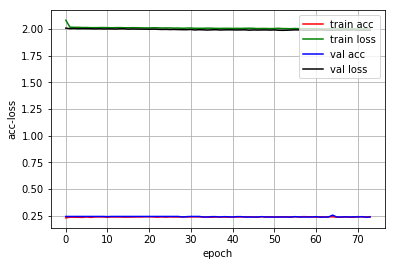

618/618 [==============================] - 0s 45us/step
test loss:  2.007176930464587
test accuracy:  0.24919093870422215


In [119]:
history.loss_plot('epoch')
loss_1, accuracy_1 = model.evaluate(test_x, test_y)
print('test loss: ', loss_1)
print('test accuracy: ', accuracy_1)

In [120]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 250)               1500      
_________________________________________________________________
activation_64 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_65 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 9)                 2259      
__________

Epoch 81/300
 - 0s - loss: 1.8771 - acc: 0.2888 - val_loss: 1.9882 - val_acc: 0.2401
Epoch 82/300
 - 0s - loss: 1.8749 - acc: 0.2881 - val_loss: 1.9879 - val_acc: 0.2509
Epoch 83/300
 - 0s - loss: 1.8771 - acc: 0.2839 - val_loss: 1.9852 - val_acc: 0.2366
Epoch 84/300
 - 0s - loss: 1.8704 - acc: 0.2877 - val_loss: 1.9861 - val_acc: 0.2563
Epoch 85/300
 - 0s - loss: 1.8753 - acc: 0.2896 - val_loss: 1.9880 - val_acc: 0.2437
Epoch 86/300
 - 0s - loss: 1.8739 - acc: 0.2885 - val_loss: 1.9918 - val_acc: 0.2491
Epoch 87/300
 - 0s - loss: 1.8678 - acc: 0.2896 - val_loss: 1.9916 - val_acc: 0.2419
Epoch 88/300
 - 0s - loss: 1.8736 - acc: 0.2888 - val_loss: 1.9895 - val_acc: 0.2384
Epoch 89/300
 - 0s - loss: 1.8700 - acc: 0.2847 - val_loss: 1.9929 - val_acc: 0.2276
Epoch 90/300
 - 0s - loss: 1.8679 - acc: 0.2857 - val_loss: 1.9828 - val_acc: 0.2473
Epoch 91/300
 - 0s - loss: 1.8651 - acc: 0.2894 - val_loss: 1.9874 - val_acc: 0.2491
Epoch 92/300
 - 0s - loss: 1.8656 - acc: 0.2932 - val_loss: 1.993

Epoch 177/300
 - 0s - loss: 1.7902 - acc: 0.3254 - val_loss: 2.0128 - val_acc: 0.2473
Epoch 178/300
 - 0s - loss: 1.7942 - acc: 0.3162 - val_loss: 2.0175 - val_acc: 0.2330
Epoch 179/300
 - 0s - loss: 1.7984 - acc: 0.3108 - val_loss: 2.0116 - val_acc: 0.2384
Epoch 180/300
 - 0s - loss: 1.7926 - acc: 0.3202 - val_loss: 2.0163 - val_acc: 0.2348
Epoch 181/300
 - 0s - loss: 1.7878 - acc: 0.3208 - val_loss: 2.0211 - val_acc: 0.2366
Epoch 182/300
 - 0s - loss: 1.7852 - acc: 0.3236 - val_loss: 2.0193 - val_acc: 0.2384
Epoch 183/300
 - 0s - loss: 1.7943 - acc: 0.3208 - val_loss: 2.0174 - val_acc: 0.2455
Epoch 184/300
 - 0s - loss: 1.7873 - acc: 0.3118 - val_loss: 2.0139 - val_acc: 0.2509
Epoch 185/300
 - 0s - loss: 1.7878 - acc: 0.3228 - val_loss: 2.0146 - val_acc: 0.2384
Epoch 186/300
 - 0s - loss: 1.7913 - acc: 0.3196 - val_loss: 2.0166 - val_acc: 0.2491
Epoch 187/300
 - 0s - loss: 1.7915 - acc: 0.3224 - val_loss: 2.0116 - val_acc: 0.2419
Epoch 188/300
 - 0s - loss: 1.7831 - acc: 0.3234 - val

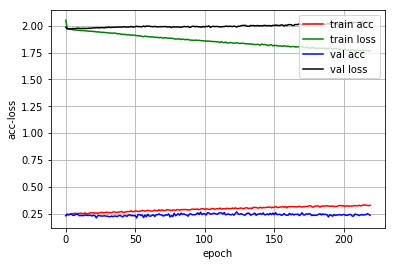

618/618 [==============================] - 0s 58us/step
test loss:  1.9832410195113
test accuracy:  0.21521035601116692


In [121]:
history.loss_plot('epoch')
loss_2, accuracy_2 = model.evaluate(test_x, test_y)
print('test loss: ', loss_2)
print('test accuracy: ', accuracy_2)

In [132]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 250)               1750      
_________________________________________________________________
activation_79 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_80 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 9)                 2259      
__________

Epoch 81/300
 - 0s - loss: 1.8299 - acc: 0.3056 - val_loss: 1.9079 - val_acc: 0.2419
Epoch 82/300
 - 0s - loss: 1.8241 - acc: 0.3126 - val_loss: 1.9062 - val_acc: 0.2599
Epoch 83/300
 - 0s - loss: 1.8239 - acc: 0.3072 - val_loss: 1.9198 - val_acc: 0.2509
Epoch 84/300
 - 0s - loss: 1.8178 - acc: 0.3030 - val_loss: 1.8958 - val_acc: 0.2670
Epoch 85/300
 - 0s - loss: 1.8125 - acc: 0.3118 - val_loss: 1.8974 - val_acc: 0.2599
Epoch 86/300
 - 0s - loss: 1.8039 - acc: 0.3140 - val_loss: 1.8907 - val_acc: 0.2491
Epoch 87/300
 - 0s - loss: 1.8033 - acc: 0.3174 - val_loss: 1.8825 - val_acc: 0.2616
Epoch 88/300
 - 0s - loss: 1.7975 - acc: 0.3160 - val_loss: 1.8843 - val_acc: 0.2527
Epoch 89/300
 - 0s - loss: 1.7937 - acc: 0.3240 - val_loss: 1.8765 - val_acc: 0.2599
Epoch 90/300
 - 0s - loss: 1.7955 - acc: 0.3140 - val_loss: 1.8627 - val_acc: 0.2796
Epoch 91/300
 - 0s - loss: 1.7753 - acc: 0.3210 - val_loss: 1.8634 - val_acc: 0.2491
Epoch 92/300
 - 0s - loss: 1.7762 - acc: 0.3250 - val_loss: 1.854

Epoch 177/300
 - 0s - loss: 1.4864 - acc: 0.4341 - val_loss: 1.6201 - val_acc: 0.3297
Epoch 178/300
 - 0s - loss: 1.4884 - acc: 0.4323 - val_loss: 1.6387 - val_acc: 0.3172
Epoch 179/300
 - 0s - loss: 1.5126 - acc: 0.4133 - val_loss: 1.6225 - val_acc: 0.3297
Epoch 180/300
 - 0s - loss: 1.4927 - acc: 0.4313 - val_loss: 1.6447 - val_acc: 0.3154
Epoch 181/300
 - 0s - loss: 1.4743 - acc: 0.4333 - val_loss: 1.6975 - val_acc: 0.2867
Epoch 182/300
 - 0s - loss: 1.4800 - acc: 0.4309 - val_loss: 1.6508 - val_acc: 0.3226
Epoch 183/300
 - 0s - loss: 1.4823 - acc: 0.4259 - val_loss: 1.6411 - val_acc: 0.3244
Epoch 184/300
 - 0s - loss: 1.4799 - acc: 0.4287 - val_loss: 1.6498 - val_acc: 0.3082
Epoch 185/300
 - 0s - loss: 1.4725 - acc: 0.4349 - val_loss: 1.6272 - val_acc: 0.3118
Epoch 186/300
 - 0s - loss: 1.4715 - acc: 0.4273 - val_loss: 1.6260 - val_acc: 0.3315
Epoch 187/300
 - 0s - loss: 1.4778 - acc: 0.4261 - val_loss: 1.6245 - val_acc: 0.3262
Epoch 188/300
 - 0s - loss: 1.4714 - acc: 0.4343 - val

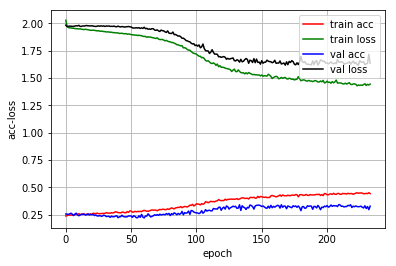

618/618 [==============================] - 0s 52us/step
test loss:  1.6547033462709593
test accuracy:  0.3300970874268646


In [133]:
history.loss_plot('epoch')
loss_3, accuracy_3 = model.evaluate(test_x, test_y)
print('test loss: ', loss_3)
print('test accuracy: ', accuracy_3)

In [129]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
print(train)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


           開盤價       最高價       最低價       收盤價         年         月         日  \
0    -0.021496 -0.026024 -0.017142 -0.021671 -0.499051  0.209821 -0.359942   
1     0.006401  0.001969  0.011417  0.006540 -0.499051  0.209821 -0.326609   
2     0.036444  0.032116  0.042173  0.036922 -0.499051  0.209821 -0.293275   
3     0.068632  0.064416  0.075126  0.069475 -0.499051  0.209821 -0.259942   
4     0.102967  0.098869  0.110275  0.104197 -0.499051  0.209821 -0.226609   
5     0.139448  0.135475  0.147621  0.141089 -0.499051  0.209821 -0.193275   
6     0.178074  0.174235  0.187164  0.180152 -0.499051  0.209821 -0.126609   
7     0.218847  0.215148  0.228904  0.221384 -0.499051  0.209821 -0.093275   
8     0.261765  0.258214  0.272841  0.264787 -0.499051  0.209821 -0.059942   
9     0.308976  0.305587  0.286022  0.312530 -0.499051  0.209821 -0.026609   
10    0.308976  0.322814  0.299203  0.303850 -0.499051  0.209821  0.006725   
11    0.300392  0.314200  0.303597  0.303850 -0.499051  0.209821

Epoch 12/300
 - 0s - loss: 1.9478 - acc: 0.2525 - val_loss: 1.9670 - val_acc: 0.2222
Epoch 13/300
 - 0s - loss: 1.9465 - acc: 0.2547 - val_loss: 1.9741 - val_acc: 0.2276
Epoch 14/300
 - 0s - loss: 1.9472 - acc: 0.2545 - val_loss: 1.9726 - val_acc: 0.2204
Epoch 15/300
 - 0s - loss: 1.9449 - acc: 0.2615 - val_loss: 1.9719 - val_acc: 0.2330
Epoch 16/300
 - 0s - loss: 1.9449 - acc: 0.2589 - val_loss: 1.9698 - val_acc: 0.2312
Epoch 17/300
 - 0s - loss: 1.9414 - acc: 0.2587 - val_loss: 1.9690 - val_acc: 0.2312
Epoch 18/300
 - 0s - loss: 1.9394 - acc: 0.2617 - val_loss: 1.9718 - val_acc: 0.2151
Epoch 19/300
 - 0s - loss: 1.9400 - acc: 0.2593 - val_loss: 1.9734 - val_acc: 0.2151
Epoch 20/300
 - 0s - loss: 1.9402 - acc: 0.2581 - val_loss: 1.9705 - val_acc: 0.2186
Epoch 21/300
 - 0s - loss: 1.9381 - acc: 0.2615 - val_loss: 1.9699 - val_acc: 0.2366
Epoch 22/300
 - 0s - loss: 1.9377 - acc: 0.2615 - val_loss: 1.9696 - val_acc: 0.2133
Epoch 23/300
 - 0s - loss: 1.9300 - acc: 0.2645 - val_loss: 1.971

Epoch 109/300
 - 0s - loss: 1.6627 - acc: 0.3553 - val_loss: 1.7459 - val_acc: 0.2885
Epoch 110/300
 - 0s - loss: 1.6578 - acc: 0.3645 - val_loss: 1.7459 - val_acc: 0.3100
Epoch 111/300
 - 0s - loss: 1.6431 - acc: 0.3617 - val_loss: 1.7264 - val_acc: 0.3029
Epoch 112/300
 - 0s - loss: 1.6509 - acc: 0.3533 - val_loss: 1.7401 - val_acc: 0.3244
Epoch 113/300
 - 0s - loss: 1.6399 - acc: 0.3587 - val_loss: 1.7222 - val_acc: 0.3208
Epoch 114/300
 - 0s - loss: 1.6236 - acc: 0.3730 - val_loss: 1.7188 - val_acc: 0.3011
Epoch 115/300
 - 0s - loss: 1.6264 - acc: 0.3730 - val_loss: 1.7138 - val_acc: 0.3244
Epoch 116/300
 - 0s - loss: 1.6246 - acc: 0.3738 - val_loss: 1.7061 - val_acc: 0.3047
Epoch 117/300
 - 0s - loss: 1.6218 - acc: 0.3706 - val_loss: 1.7067 - val_acc: 0.3208
Epoch 118/300
 - 0s - loss: 1.6108 - acc: 0.3762 - val_loss: 1.7241 - val_acc: 0.3136
Epoch 119/300
 - 0s - loss: 1.6185 - acc: 0.3712 - val_loss: 1.7073 - val_acc: 0.3172
Epoch 120/300
 - 0s - loss: 1.6150 - acc: 0.3728 - val

Epoch 205/300
 - 0s - loss: 1.4578 - acc: 0.4327 - val_loss: 1.6411 - val_acc: 0.3459
Epoch 206/300
 - 0s - loss: 1.4562 - acc: 0.4349 - val_loss: 1.6479 - val_acc: 0.3405
Epoch 207/300
 - 0s - loss: 1.4594 - acc: 0.4373 - val_loss: 1.6528 - val_acc: 0.3351
Epoch 208/300
 - 0s - loss: 1.4613 - acc: 0.4373 - val_loss: 1.6623 - val_acc: 0.3441
Epoch 209/300
 - 0s - loss: 1.4569 - acc: 0.4305 - val_loss: 1.6555 - val_acc: 0.3530
Epoch 210/300
 - 0s - loss: 1.4714 - acc: 0.4269 - val_loss: 1.6351 - val_acc: 0.3566
Epoch 211/300
 - 0s - loss: 1.4522 - acc: 0.4393 - val_loss: 1.6349 - val_acc: 0.3477
Epoch 212/300
 - 0s - loss: 1.4471 - acc: 0.4432 - val_loss: 1.6358 - val_acc: 0.3602
Epoch 213/300
 - 0s - loss: 1.4538 - acc: 0.4365 - val_loss: 1.6383 - val_acc: 0.3530
Epoch 214/300
 - 0s - loss: 1.4463 - acc: 0.4287 - val_loss: 1.6404 - val_acc: 0.3459
Epoch 215/300
 - 0s - loss: 1.4598 - acc: 0.4309 - val_loss: 1.6280 - val_acc: 0.3530
Epoch 216/300
 - 0s - loss: 1.4428 - acc: 0.4363 - val

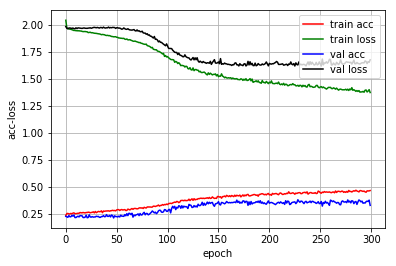

618/618 [==============================] - 0s 52us/step
test loss:  1.6994211916784638
test accuracy:  0.35598705520907653


In [130]:
history.loss_plot('epoch')
loss_4, accuracy_4 = model.evaluate(test_x, test_y)
print('test loss: ', loss_4)
print('test accuracy: ', accuracy_4)

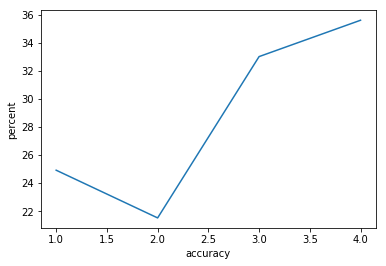

In [134]:
accuracy=[accuracy_1*100,accuracy_2*100,accuracy_3*100,accuracy_4*100]
number=[1,2,3,4]
plt.plot(number, accuracy)
plt.xlabel("accuracy")
plt.ylabel("percent")
plt.show()